## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import re

# text preprocessing
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TweetTokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# deep learning model
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from keras.layers import Embedding, Input, Dense, LSTM, GlobalMaxPooling1D, GRU, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical

# regularizers
from keras.regularizers import L1L2, l2
# Wordcloud
from wordcloud import WordCloud


### Data Import

In [ ]:
df = pd.read_csv("/content/cleaned_tweets (3).csv")


### Data Introduction

In [ ]:
df.shape

(10185, 18)

In [ ]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.018500e+04,10185.000000,6911.000000,10185.000000
mean,5.691338e+17,0.892045,0.619990,0.094060
std,7.765660e+14,0.167221,0.336282,0.689522
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.684828e+17,0.685400,0.354550,0.000000
50%,5.692714e+17,1.000000,0.668200,0.000000
75%,5.698179e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,31.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10185 entries, 0 to 10184
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      10185 non-null  int64  
 1   airline_sentiment             10185 non-null  object 
 2   airline_sentiment_confidence  10185 non-null  float64
 3   negativereason                5922 non-null   object 
 4   negativereason_confidence     6911 non-null   float64
 5   airline                       10185 non-null  object 
 6   airline_sentiment_gold        23 non-null     object 
 7   name                          10185 non-null  object 
 8   negativereason_gold           19 non-null     object 
 9   retweet_count                 10185 non-null  int64  
 10  text                          10185 non-null  object 
 11  tweet_coord                   741 non-null    object 
 12  tweet_created                 10185 non-null  object 
 13  t

In [ ]:
df.sample(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,final_text,lemmatized,tokens
6069,568319110779514880,positive,1.0,NaN,NaN,Southwest,NaN,neelaybhatt,NaN,0,@SouthwestAir Thx Ops Agt Rich Westagard n Fli...,NaN,2015-02-19 00:00:09 -0800,"Indianapolis, USA",Eastern Time (US & Canada),thx ops agt rich westagard n flight att nancy ...,thx ops agt rich westagard n flight att nancy ...,"['thx', 'ops', 'agt', 'rich', 'westagard', 'n'..."
3999,567883485542658048,negative,1.0,Customer Service Issue,0.656,United,NaN,tomcrabtree,NaN,0,@united My wife has been on the phone several ...,NaN,2015-02-17 19:09:08 -0800,San Francisco,Pacific Time (US & Canada),customer service issue my wife ha been phone s...,customer service issue my wife ha been phone s...,"['customer', 'service', 'issue', 'my', 'wife',..."
1435,569721972600528897,negative,1.0,Bad Flight,1.000,United,NaN,BrianMullane,NaN,0,@united Flight 472 from ORD couldn't let me kn...,NaN,2015-02-22 20:54:37 -0800,"52.315477,4.995852",Eastern Time (US & Canada),bad flight flight 472 ord could not let me kno...,bad flight flight 472 ord could not let me kno...,"['bad', 'flight', 'flight', '472', 'ord', 'cou..."
2539,569115097198690305,negative,1.0,Lost Luggage,1.000,United,NaN,lingley,NaN,0,@United terrible illogical re-route after Canc...,NaN,2015-02-21 04:43:07 -0800,"ÜT: 42.706796,-71.210754",Quito,lost luggage terrible illogical route cancelle...,lost luggage terrible illogical route cancelle...,"['lost', 'luggage', 'terrible', 'illogical', '..."
7963,568924781837455360,negative,1.0,Late Flight,1.000,Delta,NaN,farms122,NaN,0,@JetBlue any news on flight 122 pbi-boston del...,NaN,2015-02-20 16:06:52 -0800,NaN,Eastern Time (US & Canada),late flight news flight 122 pbi boston delay w...,late flight news flight 122 pbi boston delay w...,"['late', 'flight', 'news', 'flight', '122', 'p..."


In [ ]:
df[["final_text", "airline_sentiment"]]

,final_text,airline_sentiment
0,what said,neutral
1,plus you have added commercial experience tacky,positive
2,i did not today must mean i need take another ...,neutral
3,bad flight it is really aggressive blast obnox...,negative
4,ca not tell it is really big bad thing it,negative
...,...,...
10180,cancelled flight flight cancelled flightled du...,negative
10181,bad flight plane i am is mechanical issue why ...,negative
10182,cancelled flight good grief flight cancelled f...,negative
10183,customer service issue answer bloody phone,negative


### Text Cleaning

In [ ]:
def remove_stopwords(final_text):
    "removes stopwords"
    # customize stopwords
    my_stopwords = stopwords.words("english")
    my_stopwords.remove("not")
    # remove stopwords
    filtered_words = [word for word in text if word not in my_stopwords]
    return filtered_words

def remove_punctuation(final_text):
    "removes punctutation"
    my_punct = string.punctuation
    my_punct += "“”’" # add unusual apostrophes
    no_punct = [w for w in final_text if w not in my_punct]
    return no_punct

def remove_numbers(final_text):
    "removes strings containing only digits"
    reduced = re.sub(r'\b[0-9]+\b\s*', '', final_text)
    return reduced

def remove_signs(final_text, sign):
    "removes a particular sign"
    try:
        reduced = [w for w in final_text if sign not in w]
        return reduced
    except Exception as e:
        print(e)
        return final_text

def remove_links(final_text):
    "removes links"
    reduced = re.sub(r'http\S+', '', final_text)
    return reduced


In [ ]:
def clean_text(inp_text):
    """
        This function is a pipeline for text preprocessing
        It consists of following steps:
            - converting text to lowercase
            - removing words containing only digits
            - removing links
            - removing stopwords
            - removing punctuation
            - removing mentions and hashtags
    """
    #lowercase
    text = inp_text.lower()
    # remove only number words
    text = remove_numbers(text)
    # remove links
    text = remove_links(text)
    # divide input sentence into words
    tknzr = TweetTokenizer()
    text = tknzr.tokenize(text)
    # remove stopwords
    text = remove_stopwords(text)
    # remove punctuation
    text = remove_punctuation(text)
    # remove mentions
    text = remove_signs(text, "@")
    # remove hashtags
    text = remove_signs(text, "#")
    # join a list of words into a sentence
    filtered_sentence = (" ").join(text)
    return filtered_sentence

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def remove_stopwords(final_text):
    tokens = word_tokenize(final_text)
    my_stopwords = stopwords.words("english")
    if "not" in my_stopwords:
        my_stopwords.remove("not")
    filtered_words = [word for word in tokens if word.lower() not in my_stopwords]
    return filtered_words


In [ ]:

import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
df = df.dropna(subset=["final_text"])
df["final_text"] = df["final_text"].astype(str)
df["filtered_tweets"] = df["final_text"].apply(remove_stopwords)



In [ ]:
neg = " ".join(df[df["airline_sentiment"] == "negative"]["filtered_tweets"].map(lambda x: " ".join(x)))
neu = " ".join(df[df["airline_sentiment"] == "neutral"]["filtered_tweets"].map(lambda x: " ".join(x)))
pos = " ".join(df[df["airline_sentiment"] == "positive"]["filtered_tweets"].map(lambda x: " ".join(x)))


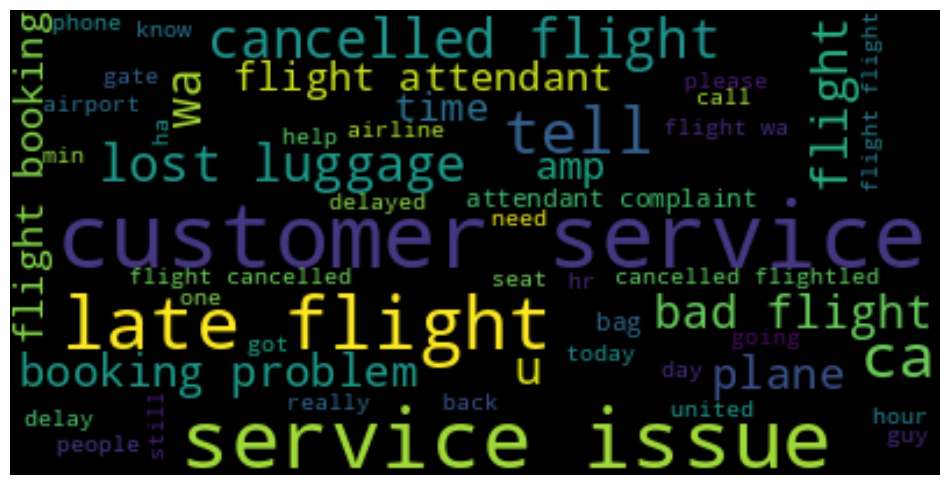

In [ ]:
plt.figure(figsize=(12, 9))
neg_cloud = WordCloud(max_words=50).generate(neg)
plt.imshow(neg_cloud, interpolation='bilinear')
plt.axis("off");

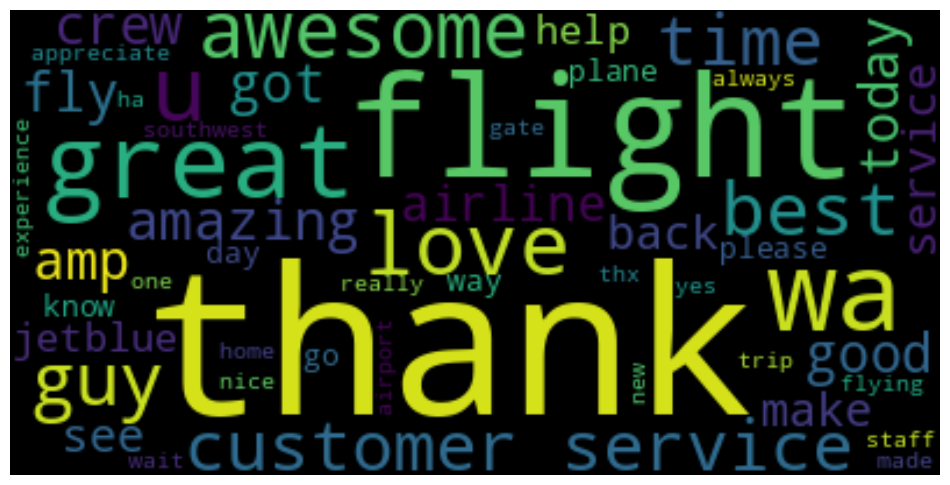

In [ ]:
plt.figure(figsize=(12, 9))
pos_cloud = WordCloud(max_words=50).generate(pos)
plt.imshow(pos_cloud, interpolation='bilinear')
plt.axis("off");

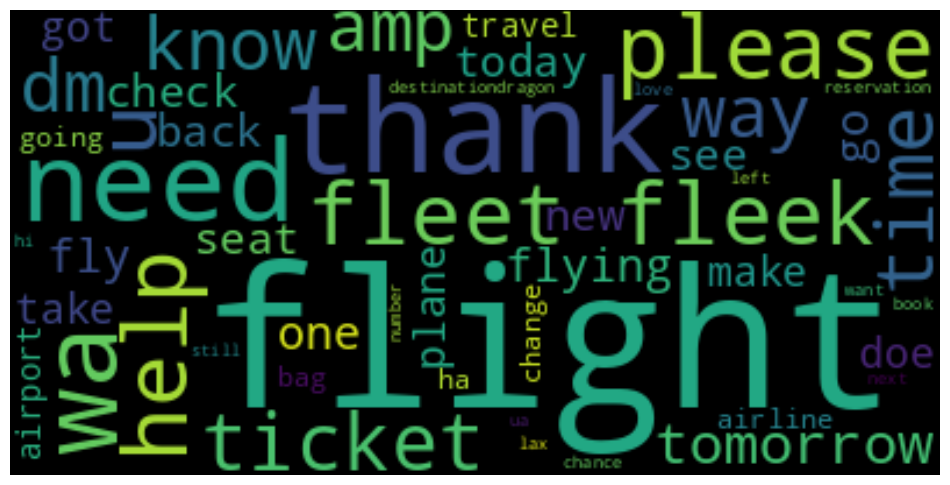

In [ ]:
plt.figure(figsize=(12, 9))
neu_cloud = WordCloud(max_words=50).generate(neu)
plt.imshow(neu_cloud, interpolation='bilinear')
plt.axis("off");

In [ ]:
def get_labels(sentiment):
    if sentiment == "negative":
        return 0
    if sentiment == "neutral":
        return 1
    if sentiment == "positive":
        return 2

df["label"] = df["airline_sentiment"].apply(get_labels)

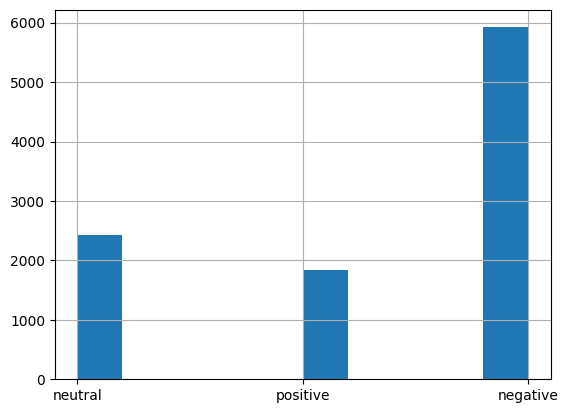

In [ ]:
df["airline_sentiment"].hist();

In [ ]:
# labels distribution
df["label"].value_counts() / df["label"].value_counts().sum()

,count
label,
0,0.581557
1,0.237749
2,0.180693


In [ ]:
train_txt, test_txt, train_labels, test_labels = train_test_split(
    df["filtered_tweets"], df["label"],
    test_size=0.2, stratify=df["label"], random_state=42)

In [ ]:
train_labels.value_counts() / train_labels.value_counts().sum()

,count
label,
0,0.581512
1,0.237785
2,0.180702


### Converting text into numbers

#### Tokenizing
In other words we split sentences into vectors of words

In [ ]:
tknz = Tokenizer()
tknz.fit_on_texts(train_txt)
train_sentences = tknz.texts_to_sequences(train_txt)
test_sentences = tknz.texts_to_sequences(test_txt)

Unique words count

In [ ]:
vocab_size = len(tknz.word_counts)
vocab_size

8477

### Add padding

We extend each vector to the length of sentence containing the most words. Padding adds 0s at the beginning by default

In [ ]:
# add padding to the train set
train_pad = pad_sequences(train_sentences)

# max length of words in a single sentence
max_len = train_pad.shape[1]

# add padding to the test set using max len
test_pad = pad_sequences(test_sentences, maxlen=max_len)

In [ ]:
train_pad.shape, test_pad.shape

((8146, 28), (2037, 28))

In [ ]:
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)
y_train[:4]

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

### Training a model

In [ ]:
# size of the Embeddings vector
D = 15
# size of the hidden vector
M = 10
# vocab size
V = vocab_size
# sequence length
T = max_len

batch_size = 32

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = LSTM(M)(x)
x = Dense(3, activation='softmax')(x)

mbasic = Model(i, x)
# model.summary()

mbasic.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

basic = mbasic.fit(train_pad, y_train, batch_size=batch_size, epochs=10, validation_data=(test_pad, y_test))

Epoch 1/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6419 - loss: 0.8333 - val_accuracy: 0.8046 - val_loss: 0.3667
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8099 - loss: 0.3439 - val_accuracy: 0.8154 - val_loss: 0.3189
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8280 - loss: 0.2965 - val_accuracy: 0.8493 - val_loss: 0.2935
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8937 - loss: 0.2667 - val_accuracy: 0.8812 - val_loss: 0.2656
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9327 - loss: 0.1982 - val_accuracy: 0.9121 - val_loss: 0.2139
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9603 - loss: 0.1221 - val_accuracy: 0.9116 - val_loss: 0.2150
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9748 - loss: 0.0812 - val_accuracy: 0.9141 - val_loss: 0.2122
Epoch 8/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9819 - loss: 0.0631 - val_accuracy: 0.

In [ ]:
# size of the Embeddings vector
D = 15
# size of the hidden vector
M = 64
# vocab size
V = vocab_size
# sequence length
T = max_len

batch_size = 32

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = LSTM(M)(x)
x = Dense(3, activation='softmax')(x)

mbig = Model(i, x)
# model.summary()

mbig.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
big = mbig.fit(train_pad, y_train, batch_size=batch_size, epochs=10, validation_data=(test_pad, y_test))


Epoch 1/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6843 - loss: 0.7230 - val_accuracy: 0.8434 - val_loss: 0.3266
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8616 - loss: 0.2934 - val_accuracy: 0.8910 - val_loss: 0.2531
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9363 - loss: 0.1718 - val_accuracy: 0.9028 - val_loss: 0.2299
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9542 - loss: 0.1189 - val_accuracy: 0.9087 - val_loss: 0.2285
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9725 - loss: 0.0759 - val_accuracy: 0.9048 - val_loss: 0.2555
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9773 - loss: 0.0629 - val_accuracy: 0.9067 - val_loss: 0.2687
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9834 - loss: 0.0485 - val_accuracy: 0.9102 - val_loss: 0.2884
Epoch 8/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9881 - loss: 0.0359 - val_accuracy: 0.

In [ ]:
# size of the Embeddings vector
D = 10
# size of the hidden vector
M = 10
# vocab size
V = vocab_size
# sequence length
T = max_len

batch_size = 32

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(3, activation='softmax')(x)

pool = Model(i, x)
# model.summary()

pool.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

lstm_pool = pool.fit(train_pad, y_train, batch_size=batch_size, epochs=10, validation_data=(test_pad, y_test))

Epoch 1/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5623 - loss: 0.9730 - val_accuracy: 0.7899 - val_loss: 0.5911
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8013 - loss: 0.5077 - val_accuracy: 0.8027 - val_loss: 0.3853
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8111 - loss: 0.3514 - val_accuracy: 0.8154 - val_loss: 0.3241
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8149 - loss: 0.3156 - val_accuracy: 0.8164 - val_loss: 0.3094
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8182 - loss: 0.2964 - val_accuracy: 0.8193 - val_loss: 0.3024
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8306 - loss: 0.2825 - val_accuracy: 0.8503 - val_loss: 0.2879
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8775 - loss: 0.2633 - val_accuracy: 0.9033 - val_loss: 0.2576
Epoch 8/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9485 - loss: 0.1873 - val_accuracy: 0

In [ ]:
# size of the Embeddings vector
D = 15
# size of the hidden vector
M = 10
# vocab size
V = vocab_size
# sequence length
T = max_len

batch_size = 32

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = LSTM(M, recurrent_dropout=0.2)(x)
x = Dense(3, activation='softmax')(x)

rec_drop = Model(i, x)
# model.summary()

rec_drop.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

rd = rec_drop.fit(train_pad, y_train, batch_size=batch_size, epochs=10, validation_data=(test_pad, y_test))

Epoch 1/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.6361 - loss: 0.8970 - val_accuracy: 0.7997 - val_loss: 0.4076
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 38s 84ms/step - accuracy: 0.8093 - loss: 0.3990 - val_accuracy: 0.8778 - val_loss: 0.2962
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.9173 - loss: 0.2513 - val_accuracy: 0.9116 - val_loss: 0.2266
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - accuracy: 0.9472 - loss: 0.1687 - val_accuracy: 0.9175 - val_loss: 0.2016
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9655 - loss: 0.1224 - val_accuracy: 0.9175 - val_loss: 0.2202
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 42s 87ms/step - accuracy: 0.9689 - loss: 0.1035 - val_accuracy: 0.9185 - val_loss: 0.2101
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 40s 84ms/step - accuracy: 0.9776 - loss: 0.0784 - val_accuracy: 0.9156 - val_loss: 0.2273
Epoch 8/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 42s 88ms/step - accuracy: 0.9790 - loss: 0.0673 - 

In [ ]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

D = 15
M = 10
V = vocab_size
T = max_len

batch_size = 32

i = Input(shape=(T,))
x = Embedding(V+1, D, mask_zero=True)(i)  # هنا خلي الـmask يتولد تلقائياً
x = LSTM(M, return_sequences=True, use_cudnn=False)(x)  # عطل cuDNN عشان يقبل الـmask
x = LSTM(M, use_cudnn=False)(x)
x = Dense(3, activation='softmax')(x)

mmask = Model(i, x)

mmask.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = mmask.fit(train_pad, y_train, batch_size=batch_size, epochs=10, validation_data=(test_pad, y_test))


Epoch 1/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.6380 - loss: 0.7837 - val_accuracy: 0.8164 - val_loss: 0.3593
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8180 - loss: 0.3376 - val_accuracy: 0.8169 - val_loss: 0.3249
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8184 - loss: 0.3073 - val_accuracy: 0.8169 - val_loss: 0.3149
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8150 - loss: 0.3043 - val_accuracy: 0.8532 - val_loss: 0.3018
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8810 - loss: 0.2586 - val_accuracy: 0.9067 - val_loss: 0.2384
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9570 - loss: 0.1500 - val_accuracy: 0.9121 - val_loss: 0.2273
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9690 - loss: 0.1110 - val_accuracy: 0.9077 - val_loss: 0.2399
Epoch 8/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9814 - loss: 0.0702 - val_accuracy: 

In [ ]:
# size of the Embeddings vector
D = 15
# size of the hidden vector
M = 10
# vocab size
V = vocab_size
# sequence length
T = max_len

batch_size = 64

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = GRU(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(3, activation='softmax')(x)

mgru = Model(i, x)
# model.summary()

mgru.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

gru = mgru.fit(train_pad, y_train, epochs=10, batch_size=batch_size, validation_data=(test_pad, y_test))

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5795 - loss: 0.9653 - val_accuracy: 0.6834 - val_loss: 0.6613
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7467 - loss: 0.5536 - val_accuracy: 0.8905 - val_loss: 0.3007
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9078 - loss: 0.2717 - val_accuracy: 0.9048 - val_loss: 0.2447
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9262 - loss: 0.2085 - val_accuracy: 0.9111 - val_loss: 0.2224
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9333 - loss: 0.1769 - val_accuracy: 0.9170 - val_loss: 0.2116
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9506 - loss: 0.1438 - val_accuracy: 0.9165 - val_loss: 0.2016
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9650 - loss: 0.1124 - val_accuracy: 0.9151 - val_loss: 0.2051
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9704 - loss: 0.0920 - val_accuracy: 0.

In [ ]:
from keras.layers import BatchNormalization, Conv1D, Flatten
# size of the Embeddings vector
D = 15
# size of the hidden vector
M = 10
# vocab size
V = vocab_size
# sequence length
T = max_len

batch_size = 64

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = Conv1D(32, kernel_size=5)(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
# x = Conv1D(32, kernel_size=3)(x)
# x = Dropout(0.2)(x)
# x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(3, activation='softmax')(x)

mcnn = Model(i, x)
# model.summary()

mcnn.compile(optimizer=Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

cnn = mcnn.fit(train_pad, y_train, batch_size=batch_size, epochs=10, validation_data=(test_pad, y_test))

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 48s 345ms/step - accuracy: 0.6152 - loss: 0.8649 - val_accuracy: 0.6961 - val_loss: 1.0033
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7577 - loss: 0.5472 - val_accuracy: 0.7516 - val_loss: 0.8029
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8581 - loss: 0.3547 - val_accuracy: 0.8297 - val_loss: 0.5679
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9201 - loss: 0.2295 - val_accuracy: 0.8753 - val_loss: 0.3770
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9440 - loss: 0.1624 - val_accuracy: 0.8876 - val_loss: 0.2894
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9638 - loss: 0.1183 - val_accuracy: 0.8876 - val_loss: 0.2728
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9788 - loss: 0.0777 - val_accuracy: 0.8930 - val_loss: 0.2847
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9801 - loss: 0.0664 - val_accuracy:

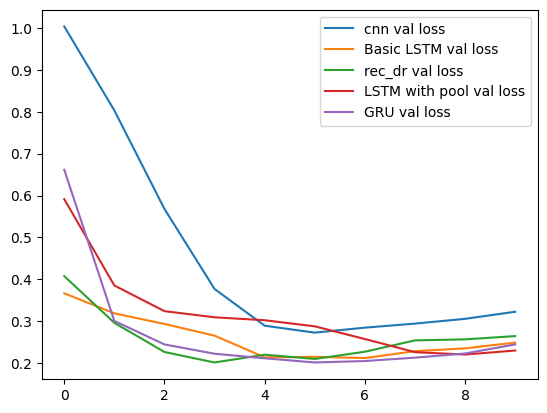

In [ ]:
plt.plot(cnn.history['val_loss'], label="cnn val loss")
plt.plot(basic.history['val_loss'], label="Basic LSTM val loss")
plt.plot(rd.history['val_loss'], label="rec_dr val loss")
plt.plot(lstm_pool.history['val_loss'], label="LSTM with pool val loss")
plt.plot(gru.history['val_loss'], label="GRU val loss")
plt.legend();

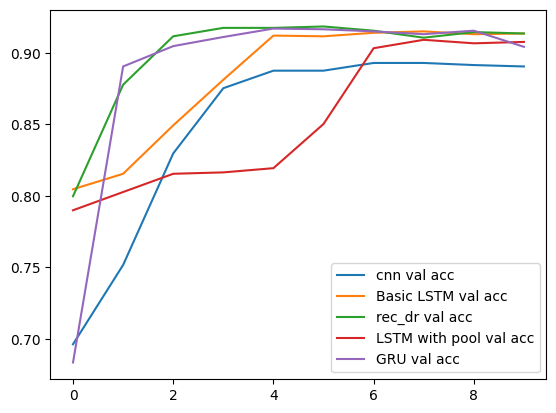

In [ ]:
plt.plot(cnn.history['val_accuracy'], label="cnn val acc")
plt.plot(basic.history['val_accuracy'], label="Basic LSTM val acc")
plt.plot(rd.history['val_accuracy'], label="rec_dr val acc")
plt.plot(lstm_pool.history['val_accuracy'], label="LSTM with pool val acc")
plt.plot(gru.history['val_accuracy'], label="GRU val acc")
plt.legend();

In [ ]:
from sklearn.metrics import confusion_matrix

pred = rec_drop.predict(test_pad)

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


In [ ]:
y_classes = pred.argmax(axis=-1)
y_classes

array([1, 1, 0, ..., 2, 0, 0])

In [ ]:
test_labels.values

array([2, 1, 0, ..., 2, 0, 0])

In [ ]:
confusion_matrix(y_classes, test_labels)

array([[1185,    4,    1],
       [   0,  403,   94],
       [   0,   77,  273]])